In [1]:
!pip install polars

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import polars as pl
import plotly.express as px

In [3]:
train_q = pl.scan_csv('data/train.csv')
lectures_q = pl.scan_csv('data/lectures.csv')
questions_q = pl.scan_csv('data/questions.csv')

In [4]:
schema = train_q.collect_schema()
print(schema)

Schema({'row_id': Int64, 'timestamp': Int64, 'user_id': Int64, 'content_id': Int64, 'content_type_id': Int64, 'task_container_id': Int64, 'user_answer': Int64, 'answered_correctly': Int64, 'prior_question_elapsed_time': Float64, 'prior_question_had_explanation': Boolean})


используем первые 5 элементов

In [5]:
train_head = train_q.head(5).collect()
print(train_head)

shape: (5, 10)
┌────────┬───────────┬─────────┬────────────┬───┬─────────────┬──────────────────┬──────────────────┬──────────────────┐
│ row_id ┆ timestamp ┆ user_id ┆ content_id ┆ … ┆ user_answer ┆ answered_correct ┆ prior_question_e ┆ prior_question_h │
│ ---    ┆ ---       ┆ ---     ┆ ---        ┆   ┆ ---         ┆ ly               ┆ lapsed_time      ┆ ad_explanation   │
│ i64    ┆ i64       ┆ i64     ┆ i64        ┆   ┆ i64         ┆ ---              ┆ ---              ┆ ---              │
│        ┆           ┆         ┆            ┆   ┆             ┆ i64              ┆ f64              ┆ bool             │
╞════════╪═══════════╪═════════╪════════════╪═══╪═════════════╪══════════════════╪══════════════════╪══════════════════╡
│ 0      ┆ 0         ┆ 115     ┆ 5692       ┆ … ┆ 3           ┆ 1                ┆ null             ┆ null             │
│ 1      ┆ 56943     ┆ 115     ┆ 5716       ┆ … ┆ 2           ┆ 1                ┆ 37000.0          ┆ false            │
│ 2      ┆ 118363

определим более узкую выборку, включающий только вопросы, без лекций

In [6]:
train_q_quest = train_q.filter(pl.col('content_type_id') == 0)

id нам не нужны, поэтому их использовать не нужно 'row_id', 'content_type_id', 'user_id', 'content_id', 'user_answer', 'task_container_id', 'prior_question_had_explanation'

а также столбец с булевым значением переведём к числовому

In [7]:
train_full = (train_q_quest.select(
    pl.all().exclude('row_id', 'content_type_id', 'user_id', 'content_id', 'user_answer', 'task_container_id', 'prior_question_had_explanation'),
    pl.col('prior_question_had_explanation').cast(pl.Float32)
).collect(streaming=True))

выводим

In [8]:
print(train_full.describe())

shape: (9, 5)
┌────────────┬─────────────┬────────────────────┬─────────────────────────────┬────────────────────────────────┐
│ statistic  ┆ timestamp   ┆ answered_correctly ┆ prior_question_elapsed_time ┆ prior_question_had_explanation │
│ ---        ┆ ---         ┆ ---                ┆ ---                         ┆ ---                            │
│ str        ┆ f64         ┆ f64                ┆ f64                         ┆ f64                            │
╞════════════╪═════════════╪════════════════════╪═════════════════════════════╪════════════════════════════════╡
│ count      ┆ 9.92713e7   ┆ 9.92713e7          ┆ 9.8878794e7                 ┆ 9.8878794e7                    │
│ null_count ┆ 0.0         ┆ 0.0                ┆ 392506.0                    ┆ 392506.0                       │
│ mean       ┆ 7.7021e9    ┆ 0.657236           ┆ 25423.810043                ┆ 0.907025                       │
│ std        ┆ 1.1595e10   ┆ 0.474634           ┆ 19948.146709                ┆ 0.

значения имеет разброс временных показателей - в дальнейшем при анализе нужно сгладить результаты с группировкой. 

Также в среднем на 66% вопросов получены верные ответы, но  и что в 91% случаев учащиеся знакомились с объяснением.

выведем первые 5 элементов файлов с информацией о вопросах и лекциях

In [9]:
lectures_head = lectures_q.head(5).collect()
questions_head = questions_q.head(5).collect()
print(lectures_head)
print(questions_head)

shape: (5, 4)
┌────────────┬─────┬──────┬──────────────────┐
│ lecture_id ┆ tag ┆ part ┆ type_of          │
│ ---        ┆ --- ┆ ---  ┆ ---              │
│ i64        ┆ i64 ┆ i64  ┆ str              │
╞════════════╪═════╪══════╪══════════════════╡
│ 89         ┆ 159 ┆ 5    ┆ concept          │
│ 100        ┆ 70  ┆ 1    ┆ concept          │
│ 185        ┆ 45  ┆ 6    ┆ concept          │
│ 192        ┆ 79  ┆ 5    ┆ solving question │
│ 317        ┆ 156 ┆ 5    ┆ solving question │
└────────────┴─────┴──────┴──────────────────┘
shape: (5, 5)
┌─────────────┬───────────┬────────────────┬──────┬────────────────┐
│ question_id ┆ bundle_id ┆ correct_answer ┆ part ┆ tags           │
│ ---         ┆ ---       ┆ ---            ┆ ---  ┆ ---            │
│ i64         ┆ i64       ┆ i64            ┆ i64  ┆ str            │
╞═════════════╪═══════════╪════════════════╪══════╪════════════════╡
│ 0           ┆ 0         ┆ 0              ┆ 1    ┆ 51 131 162 38  │
│ 1           ┆ 1         ┆ 1            

выстроим таблицу с зависимостью правильных ответов и от получения разъяснений на предыдущий вопрос.

In [13]:
print(
    train_q_quest.select(pl.col('prior_question_had_explanation'), pl.col('answered_correctly'),
                        ).drop_nulls()
    .group_by('prior_question_had_explanation')
    .agg(pl.col('answered_correctly').mean()
        ).collect(streaming=True)
)

shape: (2, 2)
┌────────────────────────────────┬────────────────────┐
│ prior_question_had_explanation ┆ answered_correctly │
│ ---                            ┆ ---                │
│ bool                           ┆ f64                │
╞════════════════════════════════╪════════════════════╡
│ true                           ┆ 0.673189           │
│ false                          ┆ 0.500629           │
└────────────────────────────────┴────────────────────┘


если учащийся получал разъяснения, то отвечал правильно на следующий вопрос в 67% случаев, иначе только в 50%.

И с другой стороны если посмотреть, то как часто учащиеся получали разъяснения после правильного/неправильного ответа. 

В данный момент необходимо сдвинуть строки в столбцах, чтобы разъяснение относилось к анализируемому вопросу

In [14]:
print(
    train_q_quest.select(        
        pl.col('prior_question_had_explanation').slice(1, None),        
        pl.col('answered_correctly').slice(0, pl.col('answered_correctly').count() - 1)
    ).group_by('answered_correctly')
    .agg(
        pl.col('prior_question_had_explanation').cast(pl.Float32).mean().alias('this_question_had_explanation')
    ).collect(streaming=True)
)

shape: (2, 2)
┌────────────────────┬───────────────────────────────┐
│ answered_correctly ┆ this_question_had_explanation │
│ ---                ┆ ---                           │
│ i64                ┆ f64                           │
╞════════════════════╪═══════════════════════════════╡
│ 0                  ┆ 0.86446                       │
│ 1                  ┆ 0.929161                      │
└────────────────────┴───────────────────────────────┘


Получили что после правильного ответа учащиеся чаще (93%) брали разъяснения, ежели чем после неправильного (86%)

Нужно выстроить зависимость правильности ответов от общего времени

In [15]:
result = ((train_q_quest.filter(
    (pl.col('timestamp') < pl.col('timestamp').quantile(0.9)) &    (pl.col('timestamp') > 300000000)
).group_by(
    (pl.col('timestamp') // 250000000).alias('time'),
).agg(
    pl.col('answered_correctly').mean().alias('mean'),
)).sort('time')
          .collect(streaming=True))

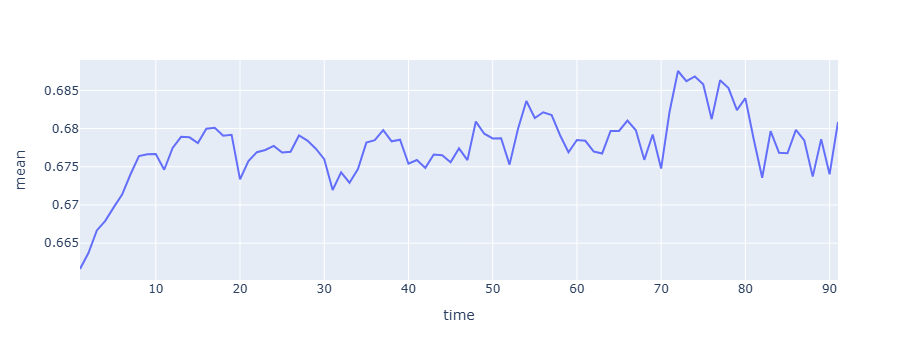

In [16]:
px.line(result, x='time', y='mean', )

На графике моюно увидить, что повышательный тренд есть, но при этом диапозон разброса значений очень небольшой

Для большей информативности посмотрим, как зависит среднее количество правильных ответов от полного времени обучения.

In [17]:
result = (train_q.group_by(
    pl.col('user_id')
).agg(    
    pl.col('row_id').count(),
    pl.col('timestamp').max().alias('time'),
    pl.col('answered_correctly').mean(),
).filter(
    pl.col('row_id') > pl.col('row_id').quantile(0.1)
).group_by(
    pl.col('time') 
).agg(
    pl.col('answered_correctly').mean()
).sort('time')
          .collect(streaming=True))

И выведем что у нас получилось!

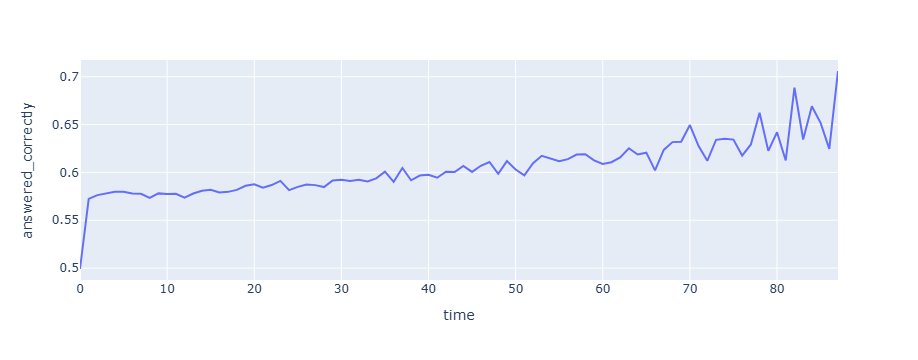

In [18]:
px.line(result, x='time', y='answered_correctly')

На графике хороша видна прямая зависимость количества правильных ответов от общего времени.

Посмотрим на зависимость правильных ответов от затраченного на вопрос времени

In [20]:
result = ((train_q.filter(
    (pl.col('prior_question_elapsed_time') < pl.col('prior_question_elapsed_time').quantile(0.95)) &
    (pl.col('prior_question_elapsed_time') > pl.col('prior_question_elapsed_time').quantile(0.05))
).select(
    pl.col('prior_question_elapsed_time').slice(1, None),
    pl.col('answered_correctly').slice(0, pl.col('answered_correctly').count() - 1)
).group_by(
    (pl.col('prior_question_elapsed_time') // 1000).alias('time')
).agg(pl.col('answered_correctly').mean()))
          .sort(pl.col('time'))
          .collect(streaming=True))

и посмотрим что из этого вышло

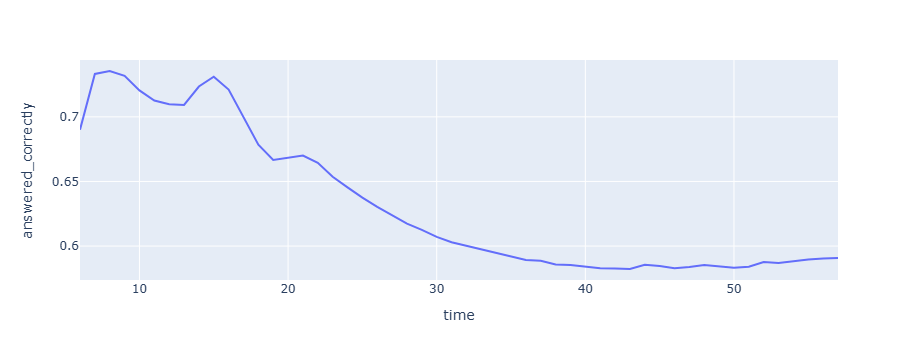

In [21]:
px.line(result, x='time', y='answered_correctly')

на графике видно, что после 15 секунд, среднее количество правильных ответов снижается

Посмотрим на связь с метаданными по вопросам. 

Для начало нужно подготовить объекты выборки

In [22]:
quest_joined_q = (train_q_quest.join(questions_q, left_on='content_id', right_on='question_id', how='left'))

In [23]:
quest_joined_split_q = quest_joined_q.with_columns(
    pl.col('tags').str.split(" ")
)

Найдем темы с наибольшим и наименьшим средним количеством правильных ответов.

In [24]:
quest_joined_expl_q = (quest_joined_split_q.select(
        pl.col('answered_correctly'),pl.col('tags'),
    ).explode('tags').group_by(
        pl.col('tags').alias('tag')
    ).agg(pl.col('answered_correctly').mean().alias('mean'),).drop_nulls().sort('mean'))

отобразим его

In [25]:
print(quest_joined_expl_q.collect(streaming=True))

shape: (188, 2)
┌─────┬──────────┐
│ tag ┆ mean     │
│ --- ┆ ---      │
│ str ┆ f64      │
╞═════╪══════════╡
│ 24  ┆ 0.385725 │
│ 23  ┆ 0.438487 │
│ 19  ┆ 0.439938 │
│ 151 ┆ 0.493155 │
│ 167 ┆ 0.500432 │
│ …   ┆ …        │
│ 40  ┆ 0.813804 │
│ 149 ┆ 0.848015 │
│ 130 ┆ 0.853152 │
│ 187 ┆ 0.85602  │
│ 68  ┆ 0.863945 │
└─────┴──────────┘


Видим, что на вопросы с тэгом=24 получено всего 38.6% правильных ответов, а на вопросы с тэгом=68 более 86%

Теперь посмотрим на такую же статистику по разделам.

In [26]:
quest_joined_expl_q = (quest_joined_split_q.select(
        pl.col('answered_correctly'),
        pl.col('part'),
    ).group_by(pl.col('part')).agg(
        pl.col('answered_correctly').mean().alias('mean'),
    ).drop_nulls().sort('mean'))

In [ ]:
посмотрим что у нас получилось:

In [27]:
print(quest_joined_expl_q.collect(streaming=True))

shape: (7, 2)
┌──────┬──────────┐
│ part ┆ mean     │
│ ---  ┆ ---      │
│ i64  ┆ f64      │
╞══════╪══════════╡
│ 5    ┆ 0.610088 │
│ 4    ┆ 0.630998 │
│ 7    ┆ 0.659601 │
│ 6    ┆ 0.669388 │
│ 3    ┆ 0.701456 │
│ 2    ┆ 0.708694 │
│ 1    ┆ 0.745032 │
└──────┴──────────┘


In [ ]:
по данным из таблицы видем, что на вопросы с темой=5 получено 61% правильных ответов, а на вопросы с темой=1 более 74%

In [28]:
result = (train_q.group_by('user_id').agg(
        pl.col('row_id').count().alias('rows'),
        (pl.col('content_type_id') == 1).sum().alias('lectures'),
        (pl.col('content_type_id') == 0).sum().alias('questions'),
        (pl.col('answered_correctly') == 1).sum().alias('correct'),
    ).filter(    
        (pl.col('rows') > pl.col('rows').quantile(0.1)) &   
        (pl.col('lectures') < pl.col('lectures').quantile(0.95))
    ).select(pl.col('lectures'), (pl.col('correct') / pl.col('questions') * 100).alias('correct_%')
    ).group_by(pl.col('lectures')
    ).agg(pl.col('correct_%').mean()
    ).sort('lectures').collect(streaming=True))

и построим график

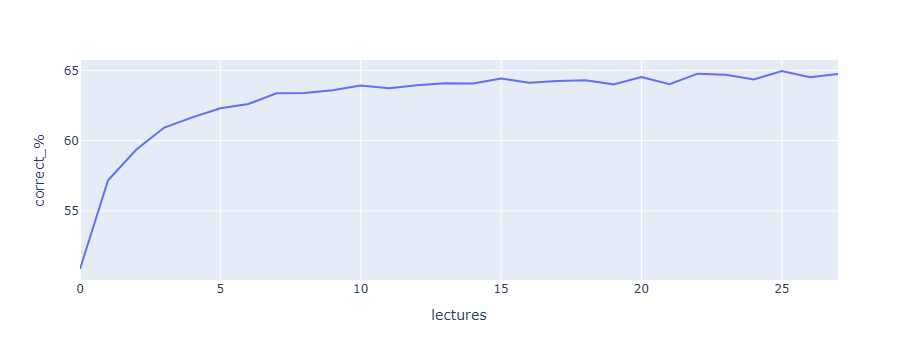

In [29]:
px.line(result, x='lectures', y='correct_%')

На данном графике видна прямая зависимость оценки от количества посещенных лекций